In [59]:
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import numpy as np
from scipy.spatial.distance import pdist, cdist, squareform
import matplotlib.pyplot as plt

In [55]:
data=pd.read_csv('../data/imputed.csv')
remove = ['EURWH_MBOE','OilEURWH_MBBL','GasEURWH_BCF',"Longitude", "Latitude"]

X = data[[column for column in data.columns if column not in remove]]
y = data['EURWH_MBOE']

xy = data[["Longitude", "Latitude"]]

In [126]:
def cross_validate (model, X, y, coords):
    cv = KFold(n_splits = 10)
    scaler = StandardScaler()

    rmse = []
    nrmse = []

    predictions = []
    ys = []

    for i, (train_index, test_index) in enumerate(cv.split(X)):
        
        print("Fold:", i + 1)
        X_train, X_test, y_train, y_test, coords_train, coords_test = X.iloc[train_index], X.iloc[train_index], y.iloc[train_index], y.iloc[train_index], coords.iloc[train_index], coords.iloc[train_index]

        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        model.fit(X_train, y_train, coords_train)
        pred = model.predict(X_test, coords_test)

        rmse.append(np.sqrt(((y_test - pred) ** 2).mean()))
        nrmse.append(np.sqrt(((y_test - pred) ** 2).mean()) / y_train.mean(axis = 0))

        predictions.append(pred)
        ys.append(y_test)

    print("Mean RMSE:", np.mean(np.array(rmse), axis = 0))
    print("Mean NRMSE:", np.mean(np.array(nrmse), axis = 0))

    return rmse, nrmse, np.hstack(predictions), np.hstack(ys)

In [127]:
from sprf import SpatialRandomForest
model = SpatialRandomForest(n_estimators = 500, neighbors = len(data) // 5)
rmse, nrmse, predictions, ys = cross_validate(model, X, y, xy)

Fold: 1


c:\Users\mathw\anaconda3\envs\COMP540\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Fold: 2


c:\Users\mathw\anaconda3\envs\COMP540\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Fold: 3


c:\Users\mathw\anaconda3\envs\COMP540\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Fold: 4


c:\Users\mathw\anaconda3\envs\COMP540\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Fold: 5


c:\Users\mathw\anaconda3\envs\COMP540\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Fold: 6


c:\Users\mathw\anaconda3\envs\COMP540\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Fold: 7


c:\Users\mathw\anaconda3\envs\COMP540\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Fold: 8


c:\Users\mathw\anaconda3\envs\COMP540\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Fold: 9


c:\Users\mathw\anaconda3\envs\COMP540\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Fold: 10


c:\Users\mathw\anaconda3\envs\COMP540\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Mean RMSE: 295.7449511853657
Mean NRMSE: 0.27956696606746434


In [129]:
# R2 Coefficient

from sklearn.metrics import r2_score

R2 = r2_score(ys, predictions)
print("Adjusted R2:", 1-(1-R2)*(len(data)-1)/(len(data)-48-1))

0.8031430267071491


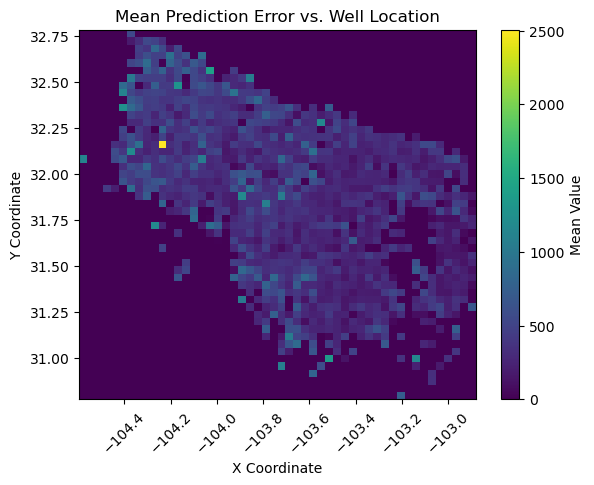

In [102]:
## Histogram of Error
error = np.abs(predictions - y)
coordinates = xy.values

# Define the number of bins in each direction
num_bins = 50

# Create a 2D histogram
hist, x_edges, y_edges = np.histogram2d(coordinates[:, 0], coordinates[:, 1], bins=num_bins, weights=error)

# Calculate the mean value within each bin
mean_values = hist / np.maximum(1, np.histogram2d(coordinates[:, 0], coordinates[:, 1], bins=num_bins)[0])

# Create a meshgrid for the plot
x_centers = (x_edges[:-1] + x_edges[1:]) / 2
y_centers = (y_edges[:-1] + y_edges[1:]) / 2
x_vals, y_vals = np.meshgrid(x_centers, y_centers)

# Plot the mean values
plt.pcolormesh(x_vals, y_vals, mean_values, cmap='viridis')
plt.colorbar(label='Mean Value')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.xticks(rotation = 45)
plt.title('Mean Prediction Error vs. Well Location')
plt.show()

In [ ]:
# Assessing spatial correlation of error
import geopandas as gpd
from pysal.explore import esda
from pysal.lib import weights

gdf = gpd.GeoDataFrame(
    X[["Longitude", "Latitude"]],
    geometry=gpd.points_from_xy(X['Longitude'], X['Latitude']),
    crs='EPSG:4326'
)

w = weights.KNN.from_dataframe(gdf, k=30)
w.transform = "R"

moran = esda.moran.Moran(error, w)
print(moran.p_sim)
print(moran.I)

Rock
1ST BONE SPRING         328.465974
2ND BONE SPRING         345.494754
2ND BONE SPRING SAND    346.300107
3RD BONE SPRING         346.477719
3RD BONE SPRING SAND    323.892122
LOWER AVALON            303.332193
MIDDLE AVALON           349.568417
UPPER AVALON            375.625055
WOLFCAMP A LOWER        336.084896
WOLFCAMP A UPPER        337.974187
WOLFCAMP B LOWER        321.205739
WOLFCAMP B UPPER        340.646081
WOLFCAMP C              361.672852
WOLFCAMP D              393.233406
Name: Error, dtype: float64


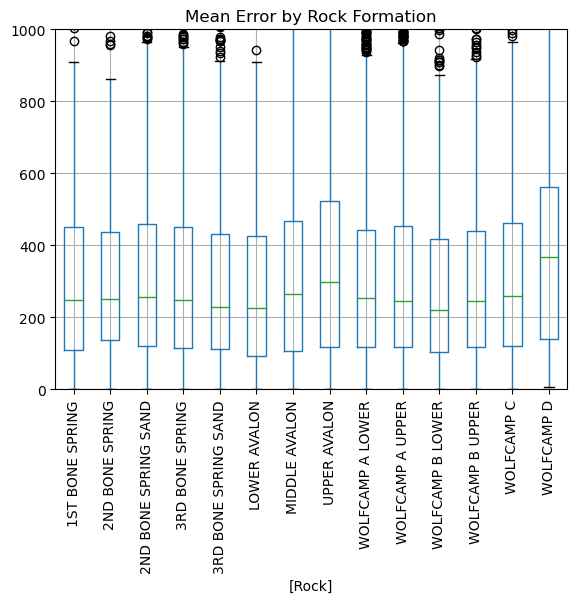

In [121]:
error_df = pd.concat((filtered["ENVInterval"], error), axis = 1)
error_df.columns = ["Rock", "Error"]
ax = error_df.boxplot(by = "Rock")

fig = ax.get_figure()
fig.suptitle('')
plt.ylim((0, 1000))
plt.xticks(rotation = 90)
plt.title("Mean Error by Rock Formation")
plt.show()

Type
CHILD           332.415064
CO-COMPLETED    334.944298
PARENT          352.316813
STANDALONE      344.586104
Name: Error, dtype: float64


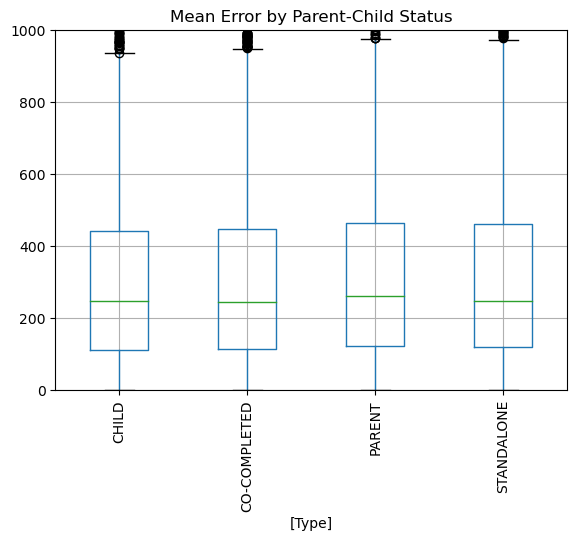

In [122]:
error_df = pd.concat((filtered["ParentChildSameZone"], error), axis = 1)
error_df.columns = ["Type", "Error"]
ax = error_df.boxplot(by = "Type")

fig = ax.get_figure()
fig.suptitle('')
plt.ylim((0, 1000))
plt.xticks(rotation = 90)
plt.title("Mean Error by Parent-Child Status")
plt.show()


Type
CONDENSATE    348.023401
DRY GAS       373.695371
OIL           337.416291
WET GAS       357.874641
Name: Error, dtype: float64


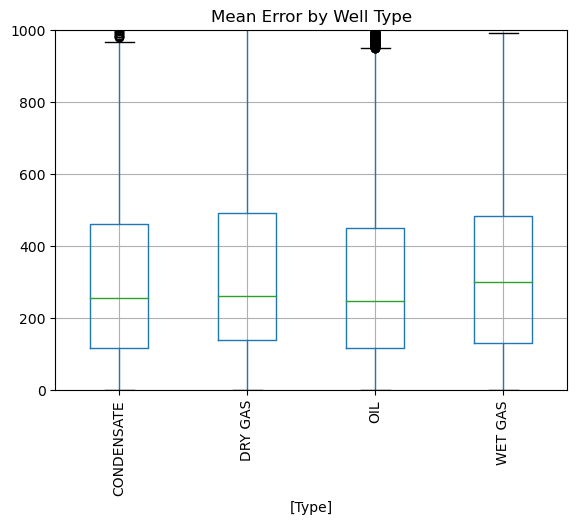

In [123]:
filtered['ENVProdWellType']= filtered['ENVProdWellType'].replace({'LIQUIDS RICH GAS (10-40% WH LIQUIDS)': 'CONDENSATE',
                                                           'OIL (40%+ WH LIQUIDS)': 'OIL',
                                                           'DRY GAS (0-1% WH LIQUIDS)':'DRY GAS',
                                                           'WET GAS (1-10% WH LIQUIDS)':'WET GAS'})

error_df = pd.concat((filtered["ENVProdWellType"], error), axis = 1)
error_df.columns = ["Type", "Error"]
ax = error_df.boxplot(by = "Type")

fig = ax.get_figure()
fig.suptitle('')

plt.ylim((0, 1000))
plt.xticks(rotation = 90)
plt.title("Mean Error by Well Type")
plt.show()

In [ ]:
# Geographical Random Forest

from sprf import GeographicalRandomForest
model = GeographicalRandomForest()
rmse, nrmse = cross_validate(model, X, y, xy)

In [ ]:
# Spatial Lag Model

from pysal.model import spreg
from pysal.lib import weights
import geopandas as gpd

gdf = gpd.GeoDataFrame(
    xy,
    geometry=gpd.points_from_xy(xy['Longitude'], xy['Latitude']),
    crs='EPSG:4326'
)

w = weights.KNN.from_dataframe(gdf, k=30)
w.transform = "R"

model = spreg.GM_Lag(
    y.values,
    X.values,
    w=w,
    # Dependent variable name
    name_y="EUR",
    # Independent variables names
    name_x=list(X.columns),
)
print(model.summary)
print(model.e_pred)